# Uber DS Interview Challenge

## Part 1 - SQL Syntax
Given the below subset of Uber’s schema, write executable SQL queries to answer the questions below.
Please answer in a single query for each question and assume readonly
access to the database (i.e. do
not use CREATE TABLE).

1. For each of the cities 'Qarth' and 'Meereen', calculate 90th percentile difference between Actual
and Predicted ETA for all completed trips within the last 30 days.

In [ ]:
select percentile_cont(0.90) WITHIN GROUP (ORDER BY (a.predicted_eta - a.actual_eta))
from trips       a  
left join cities b  on  b.city_id = a.city_id
where b.city in ('Qarth','Meereen')
and   a.status = 'completed'
and   a.request_at >= NOW() - INTERVAL '30 days' 

2. A signup is defined as an event labeled ‘sign_up_success’ within the events table. For each city
(‘Qarth’ and ‘Meereen’) and each day of the week, determine the percentage of signups in the
first week of 2016 that resulted in completed a trip within 168 hours of the sign up date.

In [ ]:
WITH c AS (
select rider_id,
       request_at,
       ROW_NUMBER() OVER (PARTITION BY rider_id order by request_at asc) as time_rank
from trips   
where status = 'completed'
)
select b.city,
       date_trunc('day', a._ts) as day_of_week,
       count(case when c.status = 'complete' then 1 else null end)/
       count(case when a.event_name = 'sign_up_success' then 1 else null end) as percentage_complete
from events       a  
left join cities  b  on  b.city_id  = a.city_id
left join     c      on  c.rider_id = a.rider_id
                     and time_rank = 1
                     and EXTRACT(EPOCH FROM a._ts-c.request_at)/3600 <=168
where b.city in ('Qarth','Meereen')
and   a.event_name = 'sign_up_success'
and   EXTRACT(WEEK FROM a._ts) = 1
and   EXTRACT(YEAR FROM a._ts) = 2016
group by b.city,date_trunc('day', a._ts)

## Part 2 - Experiment and metrics design
The Driver Experience team has just finished redesigning the Uber Partner app . The new version
expands the purpose of the app beyond just driving. It includes additional information on earnings,
ratings, and provides a unified platform for Uber to communicate with its partners.

1.Propose and define the primary success metric of the redesigned app. What are 2-3
additional
tracking metrics that will be important to monitor in addition to the success metric defined above?

Answer: 

Primary success metric: Average time to use apps, what is the average time partner using apps.

I will concern if those additional information on heat map/earning/rating/ect... can acutally is using by partners. 

Additional tracking metrics:
1. number of completed rides.  
2. Number of app tab views per partners. 
3. $Revenue generated by each partners. 

primary metric and no.2 additional metrics is description about how partners spend time/view on apps. 

No.1 and no.3 metrics is measurement how much revenue/rides is driven. 

A good app for me can do keeping user using while generating enough revenue. Those 4 metrics above should cover all 2 aspects. 


2.Outline a testing plan to evaluate if redesigned app performs better (according to the metrics you
outlined). How would you balance the need to deliver quick results, with statistical rigor, and while
still monitoring for risks?

*Answer:* 

I will planning to run a A/B testing on old and new designs if Micro Test (test for each new element adds in) not allowed in this case. 

Then we start do standard experiment procedure:

    1. Divide our test rider into 2 groups. (Randomly assign A/B group)
    
    Group A is control group(Old version app). 
    
    Group B is treatment group(New version app).
    
    Both of the group A&B will be recorded the 4 performance metric I mentioned above. (number of completed rides/Average time to use apps/Number of app tab views per partner/$Revenue generated by each partners)

    2. determine methods you are going to use. 
    
    After running test a period of time, we stop and analyze result by running a statistical test. (multiple t test in this case / or Hotelling’s T-square Test).  

    2. Define null hypothesis&Pre-define type I eror or choose alpha.  
    
    H_0: the treatment performance metrics is same as the control one.
    
    Alpha set to 0.05 generally. 


    3.  Assess power of statistical test. 

Well finally, we can get our results of multiple t test. (Reject Hypothesis or not).  
   

To balance the need to diliver quick results, with statistical rigor and while still monitorning for risk. 

Generally, extend time to run traffic to app will lead bigger/stable data, but if we want to get quick results, I will suggest run large group rider to do test. Then in this case, even running time reduced, we still can get enough test population. 

Other way is dealing outliers, I generally truncate at certain percentile of metrics of the population (like 99.0%). Or visualize data using box-plot, can get a good threshold. 


3.Explain how you would translate the results from the testing plan into a decision on whether to
launch the new design or roll it back.

*Answer:*

Using Hotelling’s T-square Test Result as example. 

Assume we are going to have Two-sample Hotelling’s T-square. 

For each group A and B will going to have performance matrix A And B after we finsih traffic split test. 
Data structure using in modeling will be:


|partner_id|Time to use apps|number of completed rides|Number of app tab views|$Revenue|
| :---------------: | :---------------: | :---------------: | :---------------: | :---------------: |
| 1               |160 seconds|5|13|120|
| 2               | 33 seconds|0|2|0|
| 3               |380 seconds|2|27|45|
| ...               |...|...|...|...|

Now we want to if A perfermance is different to B or not. 

If A Hotelling’s T-square Result will show as:
T^2 = 2412.45; F = 391.92; df = 4; p < 0.0001

p value is almost 0. 

We can conclude group A's performance is different to B.

After we conclude they are different, next step is take a look at mean table:

||Means||
| :---------------: | :---------------: | :---------------: |
||Group A|Group B|
| Time to use apps|720 seconds|630 seconds|
| number of completed rides| 5.24|4.12|
| Number of app tab views|17.87|16.64|
| Revenue|37.22|$35.17|

Also we need to take a look at individual variables section. 

for example:

Time to use apps's  p value is 0.00001

number of completed rides's  p value is 0.00001

Number of app tab views's  p value is 0.00001

Revenue's  p value is 0.2334

Revenue's p value > 0.05 --- Have no enough evidence to say revenue will change after release new version app. 

Based on above results, since for each performance metric of A is larger than control set B. And we have overall test p value < 0.0001. 

We can make decision to release new app. 

For more general case:

We will make decision to release new app if:

Overall test p value > 0.05.

And for any individual performance metrics have p -value <0.05, the mean of group A is bigger than B. That means we have high chance to improve performance metrics if we release the new app. 

Similar to the case we make decision to release new app. 

Below is case we will not release new app:

1. overall test p value > 0.05. We have no enough evidence show new app will help grow our performance metrics. 
2. overall test p value < 0.05. But:
    For any individual performance metrics have p -value <0.05, the mean of group a is smaller than B. That means we have high chance hurting some performance metric if we release the new app. 

## Part 3 - Data Analysis

Uber’s Driver team is interested in predicting which driver signups are most likely to start driving. To help
explore this question, we have provided a sample  dataset of a cohort of driver signups in January 2015.

The data was pulled a few months after they signed up to include the result of whether they actually
completed their first trip. It also includes several pieces of background information gather about the driver
and their car.

We would like you to use this data set to help understand what factors are best at predicting whether a
signup will start to drive, and offer suggestions to operationalize those insights to help Uber.
See below for a detailed description of the dataset. Please include any code you wrote for the analysis
and delete the dataset when you have finished with the challenge. Please also call out any data related
assumptions or issues that you encounter.

1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this
analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver
signups took a first trip?​ (2 points)

*Answers:*

My general procedure to clean up data and process features information. 
1. for all categorical data: create dummy variable for each field.
2. for all datetime data convert to datetime. 
3. For each field contain Null, generate variable xx_null (1/0 - is null or not)
4. calculate necessay field based on current problems. 
    1. Time difference between signip and background check complete
    2. Time difference between signip and vehicle added date
5. Visualization data for explore more information

Below is code using to process data


###### Read in data

In [1]:
import numpy as np
import pandas as pd
import csv
import re
from IPython.display import display

in_file = 'C:/Users/wen.zhang/Documents/python/projects/uber/sTEF.csv'
full_data = pd.read_csv(in_file)

print "finished read in data"

#display(full_data.head())

finished read in data


###### pre-processing datetime/categorical/null data

In [2]:
#processing categorical variable
from sklearn import preprocessing
for column in full_data:
    if column in ('city_name','signup_os', 'signup_channel', 'vehicle_make','vehicle_model'):
        new_col = pd.get_dummies(full_data[column], prefix=column, dummy_na=True)
        full_data = pd.concat([full_data, new_col], axis=1)

print "preprocessing categorical data"

#converting date object to date
full_data['signup_date'] = pd.to_datetime(full_data['signup_date'])
full_data['bgc_date'] = pd.to_datetime(full_data['bgc_date'])
full_data['vehicle_added_date'] = pd.to_datetime(full_data['vehicle_added_date'])
full_data['first_completed_date'] = pd.to_datetime(full_data['first_completed_date'])

print "preprocessing datetime data"

new_features= pd.DataFrame(columns=[['id','isstart','null_bgc','null_vad','bgc_diff','vad_diff']])
#processing target variable and null date feature and other calculation features
for index, row in full_data.iterrows():
    temp_id = row['id']
    #processing null value in date
    if pd.isnull(row['first_completed_date']) == True:
        temp_isstart = 0
    else:
        temp_isstart = 1
    if pd.isnull(row['bgc_date']) == True:
        temp_null_bgc = 1
    else:
        temp_null_bgc = 0
    if pd.isnull(row['vehicle_added_date']) == True:
        temp_null_vad = 1
    else:
        temp_null_vad = 0
    #processing date diff between signup date and other date
    if pd.isnull(row['bgc_date']) == False:
        bgc_diff = float((row['bgc_date'] - row['signup_date']).days)
    else:
        bgc_diff = 0
    if pd.isnull(row['vehicle_added_date']) == False:
        vad_diff = float((row['vehicle_added_date'] - row['signup_date'] ).days)
    else:
        vad_diff = 0
        
    new_features = new_features.append(pd.DataFrame([[temp_id,temp_isstart, temp_null_bgc,temp_null_vad,bgc_diff,vad_diff]],
                                                    columns=['id','isstart','null_bgc','null_vad','bgc_diff','vad_diff']))
                                                  
new_features.index = range(len(new_features))
full_data = pd.merge(full_data, new_features, on = 'id')

print "preprocessing datetime/self-calculation data"

#fill null data
for column in full_data:
    if column not in ('id','city_name','signup_os', 'signup_channel', 'vehicle_make','vehicle_model','signup_date','bgc_date'
                      ,'first_completed_date','vehicle_added_date','isstart'):
        mean_value = int(float(full_data[column].mean(skipna=True, axis=0)))
        full_data[column].fillna(mean_value, inplace=True)
        
print "preprocessing null data"

        
# RANDOM SHUFFLE DATA
full_data_final = full_data.iloc[np.random.permutation(len(full_data))]
full_data_final.index = range(len(full_data_final))

#drop text and unuseful field
target = full_data_final['isstart']
target = [np.int(x) for x in target]

full_data_final.drop(
    ['id', 'isstart', 'first_completed_date','city_name' ,'signup_os', 'signup_channel', 'vehicle_make','vehicle_model',
     'signup_date', 'bgc_date', 'vehicle_added_date'],
    axis=1, inplace=True)

print "finished pre-processing data"

preprocessing categorical data
preprocessing datetime data
preprocessing datetime/self-calculation data
preprocessing null data
finished pre-processing data


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Note:
1. vad_diff: Days difference between Signup date and Vehicle added (0 assign if Vehicle added date is NULL)
2. bgc_diff: Days difference between Signup date and backgroud check (0 assign if background check date is NULL)
3. null_vad: if Vehicle added date is NULL
4. null_bgc: if Background check date is NULL

###### fraction of the driver signups took a first trip

In [3]:
#print fraction of the driver signups took a first trip
n_records = len(full_data)
n_ftrip   = len(full_data[full_data.isstart == 1])
ftrip_rate = float(n_ftrip)/float(n_records)*100.0

#fraction of the driver signups took a first trip
print "Number of Signips: {}".format(n_records)
print "Number of Signips did their first trip:{}".format(n_ftrip)
print "fraction of the driver signups took a first trip: {:.2f}%".format(ftrip_rate)

Number of Signips: 54681
Number of Signips did their first trip:6137
fraction of the driver signups took a first trip: 11.22%


###### Visualized data

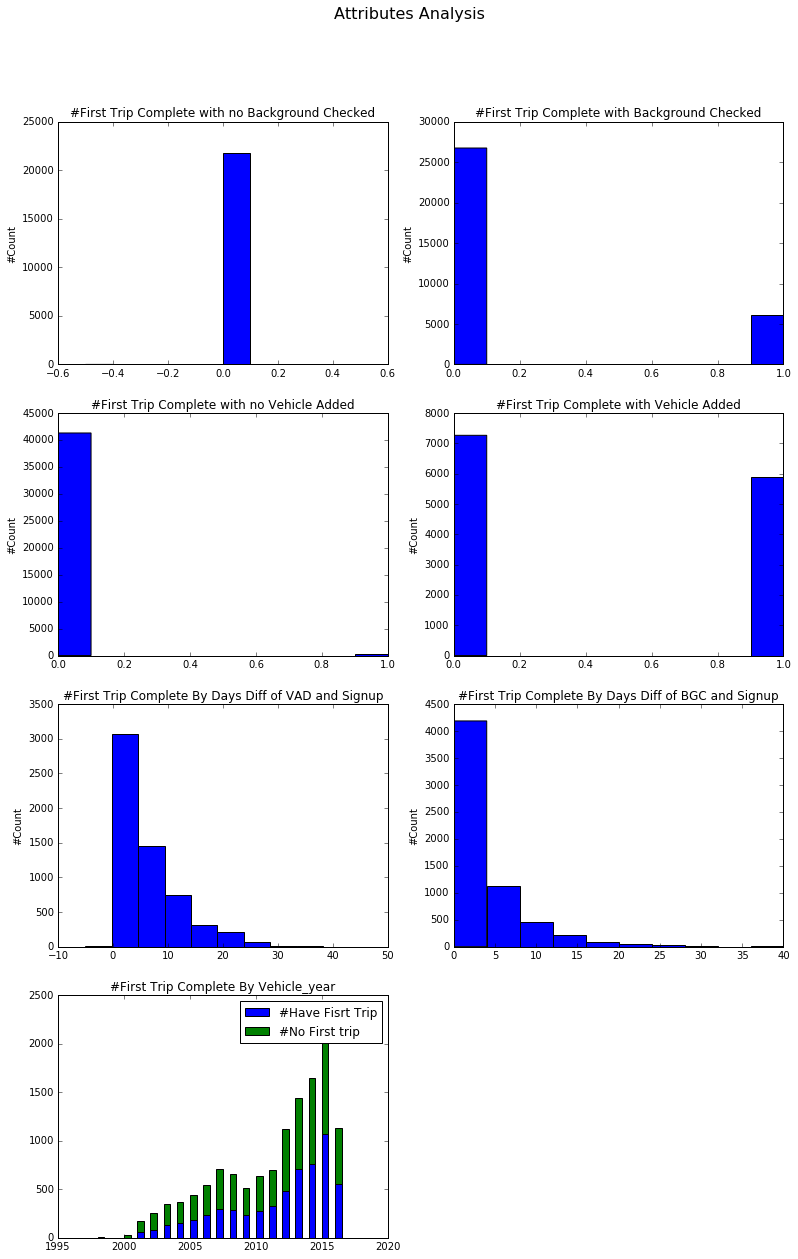

In [32]:
#visualization data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13, 20))
fig.suptitle("Attributes Analysis", fontsize=16)
ax1 = plt.subplot("421")
ax1.set_title("#First Trip Complete with no Background Checked")
ax1.hist(full_data['isstart'][full_data.null_bgc==1])
ax1.set_ylabel('#Count')

ax2 = plt.subplot("422")
ax2.set_title("#First Trip Complete with Background Checked")
ax2.hist(full_data['isstart'][full_data.null_bgc==0])
ax2.set_ylabel('#Count')

ax3 = plt.subplot("423")
ax3.set_title("#First Trip Complete with no Vehicle Added")
ax3.hist(full_data['isstart'][full_data.null_vad==1])
ax3.set_ylabel('#Count')

ax4 = plt.subplot("424")
ax4.set_title("#First Trip Complete with Vehicle Added")
ax4.hist(full_data['isstart'][full_data.null_vad==0])
ax4.set_ylabel('#Count')

ax5 = plt.subplot("425")
ax5.set_title("#First Trip Complete By Days Diff of VAD and Signup")
ax5.hist(full_data['vad_diff'][(full_data.null_vad==0) & (full_data.isstart==1)])
ax5.set_ylabel('#Count')

ax6 = plt.subplot("426")
ax6.set_title("#First Trip Complete By Days Diff of BGC and Signup")
ax6.hist(full_data['bgc_diff'][(full_data.null_bgc==0) & (full_data.isstart==1)])
ax6.set_ylabel('#Count')

group1 = full_data[['vehicle_year','isstart']][(full_data.null_vad==0) & (full_data.isstart==1)].groupby('vehicle_year').count()
group1 = group1.reset_index(level=['vehicle_year'])
group2 = full_data[['vehicle_year','isstart']][(full_data.null_vad==0) & (full_data.isstart==0)].groupby('vehicle_year').count()
group2 = group2.reset_index(level=['vehicle_year'])
group3 = group1.merge(group2,how='outer',on='vehicle_year')
width = 0.5
ax7 = plt.subplot("427")
ax7.set_title("#First Trip Complete By Vehicle_year")
ax7.bar(group3['vehicle_year'],group3['isstart_x'], width, color='b')
ax7.bar(group3['vehicle_year'],group3['isstart_y'], width, color='g', bottom=group3['isstart_x'])
ax7.legend(('#Have Fisrt Trip', '#No First trip'))

# group1 = full_data[['vehicle_make','isstart']][(full_data.null_vad==0) & (full_data.isstart==1)].groupby('vehicle_make').count()
# group1 = group1.reset_index(level=['vehicle_make'])
# group2 = full_data[['vehicle_make','isstart']][(full_data.null_vad==0) & (full_data.isstart==0)].groupby('vehicle_make').count()
# group2 = group2.reset_index(level=['vehicle_make'])
# group3 = group1.merge(group2,how='outer',on='vehicle_make')
# group3['rank'] = group3.index
# group3.index = group3['vehicle_make']
# width = 0.5
# ax8 = plt.subplot("428")
# ax8.set_title("#First Trip Complete By Vehicle Maker")
# ax8.bar(group3['rank'],group3['isstart_x'], width, color='b')
# ax8.bar(group3['rank'],group3['isstart_y'], width, color='g', bottom=group3['isstart_x'])
# ax8.legend(('#Have Fisrt Trip', '#No First trip'))

plt.show()

Notes:
1. VAD is : Vechicle Added Date
2. BGC is : Background Checked Date

##### From Above chart, we can see any driver do not have background checked will not have first-ride, but if a driver do not have vechile added, still there is a small percentage of rider can have first-ride. 
##### fraction of the driver signups took a first trip: 11.22% 
##### Logistics Regression or Other classification Algorithm can all handle this problem. 

2.Build a predictive model to help Uber determine whether or not a driver signup will start driving.
Discuss why you chose your approach, what alternatives you considered, and any concerns you
have. How valid is your model? Include any key indicators of model performance.​ (2 points)

###### First of All, we want to see what is the feature importance looks like

In [15]:
#Calculate feature importance using RandomForest
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
randomforest = RandomForestClassifier(random_state=24, n_estimators=100)
randomforest.fit(full_data_final, target)
# display the relative importance of each attribute            
top_features = np.array(sorted(zip(map(lambda x: round(x, 4), randomforest.feature_importances_), full_data_final.columns),
                               reverse=True)[:20])

top_f_name = list(top_features[:,1])
full_data_reduced = full_data_final[top_f_name]
top_f_score = top_features[:,0]

print "feature importance calculation finished"

feature importance calculation finished


finish pre-processing


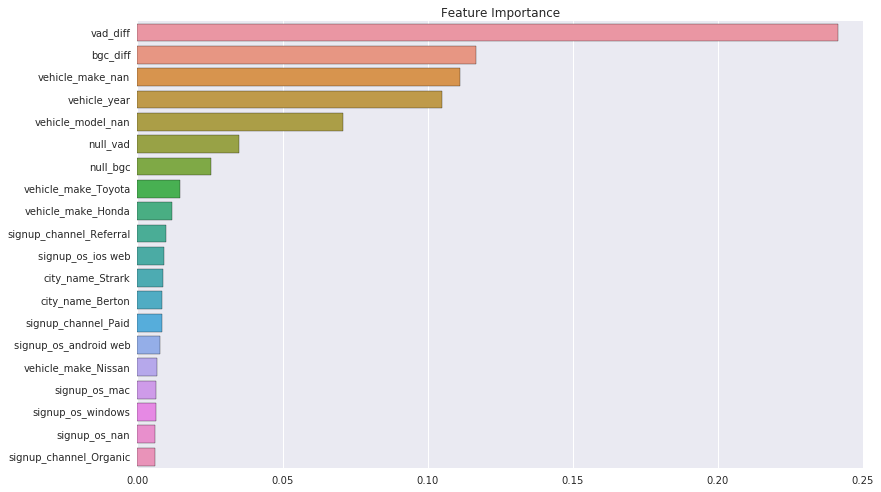

In [16]:
#plot top 20 features
%matplotlib inline
plt.figure(figsize=(13, 8))
plt.title("Feature Importance")
importance = [np.float(x) for x in top_features[:,0]]
sns.barplot(y=full_data_reduced.columns, x=importance)
print 'finish pre-processing'

Note:
1. vad_diff: Days difference between Signup date and Vehicle added (0 assign if Vehicle added date is NULL)
2. bgc_diff: Days difference between Signup date and backgroud check (0 assign if background check date is NULL)
3. null_vad: if Vehicle added date is NULL
4. null_bgc: if Background check date is NULL
5. Vehicle_model_nan: if Vehicle model is NULL
6. Vehicle_make_nan: if Vehicle make is NULL

##### Next I decide to use  both RandomForeast, Adaboost  and Logistic Regression to do modeling and model performance metrics is f1 score. (f1 score can cover precision and recall requirements.). General sense those algorithm's performance will not have too big difference. 
##### In order to avoid overfitting, a cross-validation include in model build. (try to select the best n_estimator). 
##### Total there is 446 features in data now, curse of dimensionality will take effect.  So I tried PCA to do a dimension reduction. 

In [ ]:
#Try to find best number of PCA/FA components
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV


n_components = np.arange(0, len(full_data_final.columns)/4, 10)  # options for n_components

def compute_scores(X):
    pca = PCA()
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

pca_scores, fa_scores = compute_scores(full_data_final)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)

We can see best PCA N components is 10. 

Let's run a PCA dimensional reduction using n-components equal 10

In [27]:
#Try PCA do a dimensional reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
full_data_pca = pca.fit_transform(full_data_final)

In [ ]:
# Run Logistic Regression

#Random Forest
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
randomforest = RandomForestClassifier(random_state=24, n_estimators=100)
tree_score = make_scorer(f1_score, greater_is_better=True)
parameters = {'max_depth': [x for x in range(1, 10)], 'min_samples_split': [x * 10 for x in range(5, 10)]}
clf_rf = grid_search.GridSearchCV(estimator=randomforest, param_grid=parameters, cv=10, scoring=tree_score)
clf_rf.fit(full_data_pca,target)
print "best parameter Random Forest", clf_rf.best_estimator_
print "best score  Random Forest", clf_rf.best_score_
 
print 'finish Random Forest'
 
#AdaBoost Tree

target1 = np.array(target)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn import cross_validation

# tree_score= make_scorer(output_restric ,greater_is_better=False)
tree_score = make_scorer(f1_score, greater_is_better=True)

parameters = {'learning_rate': [x * 0.1 for x in range(1, 11)]}
score_record = pd.DataFrame(columns=['Depth','Score'])
kf = cross_validation.KFold(len(full_data_final), n_folds=10)
for max_depth in range(1, 5):
    for min_ss in [x*10 for x in range(3,10)]:
        average_score = 0.0
        for train, test in kf:
            X_train, X_test, Y_train, Y_test = full_data_pca[train], full_data_pca[test], target1[
                train], target1[test]
            finalAdaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_ss),
                                           n_estimators=100,
                                           learning_rate=0.1,
                                           random_state=42)
            finalAdaB.fit(X_train, Y_train)
            average_score += f1_score(Y_test, finalAdaB.predict(X_test))
        score_record = score_record.append(pd.DataFrame([[max_depth, average_score/10]], columns=['Depth', 'Score']))
best_score_ada = max(score_record['Score'])

print 'Best AdaBoost Parameter is', score_record[score_record.Score = best_score_ada]
print 'Best AdaBoost Score is', best_score_ada

print 'finish Adaboost Decision Tree'


# Logistic Regression
from sklearn import grid_search
from sklearn import linear_model
from sklearn.metrics import make_scorer, f1_score, accuracy_score

LogisticReg = linear_model.LogisticRegression(max_iter=100)
parameters = {'C': np.arange(0.01, 2, 0.01)}
lreg_score = make_scorer(f1_score, greater_is_better=True)

clf_lReg = grid_search.GridSearchCV(estimator=LogisticReg, param_grid=parameters, cv=10, scoring=lreg_score)
clf_lReg.fit(full_data_pca,target)
print "best parameter original", clf_lReg.best_estimator_
print "best score original", clf_lReg.best_score_



##### Result of each model performance is below:

In [ ]:
Random Forest Best Score:  0.755443513291
 best parameter Random Forest 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=80,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False)
            
AdaBoost Decision Tree Best Score: 0.754700719426
Best parameter is min_samples_split=50, max_depth=2

Logistic Regression Best Score: 0.754783140551
 best parameter Logistic Regression:
 best parameter original LogisticRegression(C=0.089999999999999997, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
 

There is no two much performance difference between each model.But Random Forest Performance slit better. 

Now Run Random Forest for both dimensional reduced data and original data(For human understand purpose).
Model for xxx get highest F1 score. 
I will going to use its best estimator to refit the whole data set.

In [36]:

#Use Reduced to fit the best model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score

clf_RF_reduced = RandomForestClassifier(min_samples_split=80,max_depth=7,random_state=24, n_estimators=1000)
clf_RF_reduced.fit(full_data_pca,target)
print "Reduced Model F1 Score", f1_score(target,clf_RF_reduced.predict(full_data_pca))
print "Reduced Model Accuracy", accuracy_score(target,clf_RF_reduced.predict(full_data_pca))
print('finished modeling')

Reduced Model F1 Score 0.770750988142
Reduced Model Accuracy 0.946965124998
finished modeling


I tried to do a grdsearch using full data and random forest, the best score is still stay on around 0.755. No big change for results stand point. So I will keep to use Reduced Dataset for future modeling and predictions. 

##### All above steps is how I do a general modeling, Key model performance indicator is F1 score. (I normally use F1 score when not multi-variate classification) . 


3.Briefly discuss how Uber might leverage the insights gained from the model to generate more first
trips (again, a few ideas/sentences will suffice). (1 point)

*Answer*:

As we can see from Attributs Graphs above:
1. Add Vechile and Do a background check really matter for if a driver to do a first trip or not. 
2. The shorter days difference beween signup date and Add Vechile date, higher chance the driver will do first trip. 
3. The shorter days difference beween signup date and background checked date, higher chance the driver will do first trip.
4. Driver must do background check before drive. 
5. Japanese brand car stands out; (Toyota and Honda. I have a guess want to verify: if the added car have good gas efficiency, will it have more chance to have first trip?)

Based on above facts, try idea we can try:
1. push driver to do background check : sending out email reminder, customer phone call to help them set up. 
2. push driver to add vechicles : sending out email reminder, customer phone call to help them set up. Similar to no1.

## Summary and Thoughts of Test

For the last modeling problem:
Some options I want to try but don't have time, so I just put it here:
1. Do a stepwise feature selection in Logistic Regression
2. Try Polynomial term

Above two may can get better model performance. 